In [ ]:
! pip install transformers datasets
! pip install pyarabic
! pip install livelossplot

# Import Libraries

In [7]:
import string
import re
import os
import pickle
from os import walk
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
import unicodedata
import joblib
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, TimeDistributed, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## Load train & test

In [9]:
# ARABIC_LETTERS & diacritic lists
ARABIC_LETTERS = frozenset([chr(x) for x in (list(range(0x0621, 0x63B)) + list(range(0x0641, 0x064B)))])
diacritic = ['َ', 'ً', 'ُ', 'ٌ', 'ِ', 'ٍ', 'ْ', 'ّ', 'َّ', 'ًّ', 'ُّ', 'ٌّ', 'ِّ', 'ٍّ','']

num_char = len(ARABIC_LETTERS)+1

# Specify the directory path where the files are located
load_directory = '/content/drive/MyDrive/Utils'

# Load x_train
with open(os.path.join(load_directory, 'X_train.pkl'), 'rb') as f:
    x_train = pickle.load(f)

# Load y_train
with open(os.path.join(load_directory, 'y_train.pkl'), 'rb') as f:
    y_train = pickle.load(f)

# Load x_val
with open(os.path.join(load_directory, 'X_val.pkl'), 'rb') as f:
    x_val = pickle.load(f)

# Load y_val
with open(os.path.join(load_directory, 'y_val.pkl'), 'rb') as f:
    y_val = pickle.load(f)

In [10]:
#check the length

print('X_train = ',len(x_train))
print('y_train = ',len(y_train))

print('X_test = ',len(x_val))
print('y_test = ',len(y_val))

X_train =  57600
y_train =  57600
X_test =  2400
y_test =  2400


### Model

In [11]:
input_word = Input(shape=(100,))
model = Embedding(input_dim=num_char, output_dim=64, input_length=100)(input_word)
model = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2))(model)
model = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2))(model)
out = TimeDistributed(Dense(len(diacritic), activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 64)           2368      
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 128)         98816     
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 100, 15)          1935      
 ibuted)                                                         
                                                             

In [12]:
chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='max', baseline=None, restore_best_weights=True)
callbacks = [PlotLossesCallback(), chkpt, early_stopping]

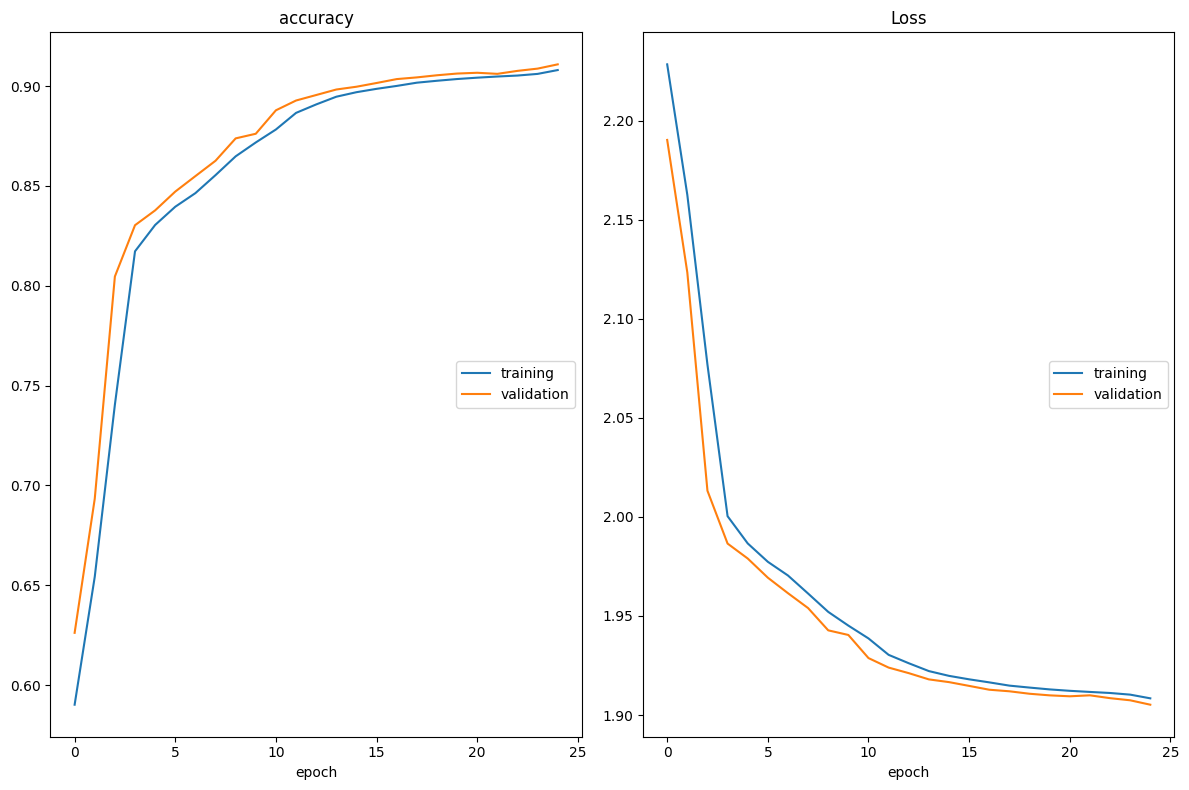

accuracy
	training         	 (min:    0.590, max:    0.908, cur:    0.908)
	validation       	 (min:    0.626, max:    0.911, cur:    0.911)
Loss
	training         	 (min:    1.908, max:    2.228, cur:    1.908)
	validation       	 (min:    1.905, max:    2.190, cur:    1.905)

Epoch 25: val_loss improved from 1.90744 to 1.90521, saving model to model_weights.h5
1800/1800 [==============================] - 1532s 851ms/step - loss: 1.9084 - accuracy: 0.9080 - val_loss: 1.9052 - val_accuracy: 0.9109
CPU times: total: 1d 6h 30min 37s
Wall time: 7h 36min 53s


In [ ]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit(
x=x_train,
y=y_train,
validation_data=(x_val,y_val),
batch_size=32,
epochs=25,
callbacks=callbacks,
verbose=1)

# *Save & Load*

In [ ]:
model.save('model')
model.save('ModelDiac/my_model')